# 1. Build an image segmentation model using pytorch

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BirdSoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        image = image.resize(self.target_size)
        mask = mask.resize(self.target_size)
        
        mask = np.array(mask) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = BirdSoundDataset(
    "/kaggle/input/project3/new_dataset/train/images", 
    "/kaggle/input/project3/new_dataset/train/masks", 
    transform, 
    target_size=(256, 256)
)
valid_dataset = BirdSoundDataset(
    "/kaggle/input/project3/new_dataset/valid/images", 
    "/kaggle/input/project3/new_dataset/valid/masks", 
    transform, 
    target_size=(256, 256)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

print("Train Loader:")
for images, masks in train_loader:
    print(f"Images batch shape: {images.shape}, Masks batch shape: {masks.shape}")
    break

print("\nValidation Loader:")
for images, masks in valid_loader:
    print(f"Images batch shape: {images.shape}, Masks batch shape: {masks.shape}")
    break


Using device: cuda
Train Loader:
Images batch shape: torch.Size([16, 3, 256, 256]), Masks batch shape: torch.Size([16, 1, 256, 256])

Validation Loader:
Images batch shape: torch.Size([16, 3, 256, 256]), Masks batch shape: torch.Size([16, 1, 256, 256])


In [2]:
import torch
import os

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AtrousConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(AtrousConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, base_channels=64):
        super(Encoder, self).__init__()
        self.enc1 = AtrousConvBlock(in_channels, base_channels, dilation=1)
        self.enc2 = AtrousConvBlock(base_channels, base_channels * 2, dilation=2)
        self.enc3 = AtrousConvBlock(base_channels * 2, base_channels * 4, dilation=4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        return x1, x2, x3


class Decoder(nn.Module):
    def __init__(self, base_channels=64):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec1 = AtrousConvBlock(base_channels * 2, base_channels * 2, dilation=1)

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec2 = AtrousConvBlock(base_channels, base_channels, dilation=1)

        self.final = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x1, x2, x3):
        d1 = self.up1(x3) + x2
        d1 = self.dec1(d1)
        d2 = self.up2(d1) + x1
        d2 = self.dec2(d2)
        out = self.final(d2)
        return out


class AtrousSegNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super(AtrousSegNet, self).__init__()
        self.encoder = Encoder(in_channels, base_channels)
        self.decoder = Decoder(base_channels)

    def forward(self, x):
        x1, x2, x3 = self.encoder(x)
        out = self.decoder(x1, x2, x3)
        return out

model = AtrousSegNet(in_channels=3, base_channels=64)

dummy_input = torch.randn(16, 3, 256, 256)

output = model(dummy_input)

output_shape = output.shape
output_shape

torch.Size([16, 1, 256, 256])

# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [4]:
from sklearn.metrics import jaccard_score
from tqdm import tqdm

def calculate_iou(y_true, y_pred):
    y_true = (y_true > 0.5).float().view(-1).cpu().numpy()
    y_pred = (y_pred > 0.5).float().view(-1).cpu().numpy()
    return jaccard_score(y_true, y_pred, average="binary")

model = AtrousSegNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 128
best_val_iou = 0.0
best_model_state = None

train_losses, val_losses = [], []
val_ious = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            val_iou += calculate_iou(masks, torch.sigmoid(outputs))

    val_loss /= len(valid_loader)
    val_iou /= len(valid_loader)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_state = model.state_dict()

if best_model_state is not None:
    torch.save(best_model_state, "best_model.pth")
    print(f"Best model saved with Val IoU: {best_val_iou:.4f}")


Validation Epoch 1/128: 100%|██████████| 13/13 [00:32<00:00,  2.46s/it]


Epoch 1/128: Train Loss: 0.5213, Val Loss: 0.3660, Val IoU: 0.5026


Validation Epoch 2/128: 100%|██████████| 13/13 [00:29<00:00,  2.23s/it]


Epoch 2/128: Train Loss: 0.3727, Val Loss: 0.3285, Val IoU: 0.5346


Validation Epoch 3/128: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


Epoch 3/128: Train Loss: 0.3197, Val Loss: 0.2884, Val IoU: 0.5507


Validation Epoch 4/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 4/128: Train Loss: 0.2855, Val Loss: 0.2727, Val IoU: 0.5773


Validation Epoch 5/128: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 5/128: Train Loss: 0.2584, Val Loss: 0.2408, Val IoU: 0.5868


Validation Epoch 6/128: 100%|██████████| 13/13 [00:28<00:00,  2.17s/it]


Epoch 6/128: Train Loss: 0.2361, Val Loss: 0.2149, Val IoU: 0.6076


Validation Epoch 7/128: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 7/128: Train Loss: 0.2189, Val Loss: 0.2060, Val IoU: 0.5946


Validation Epoch 8/128: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Epoch 8/128: Train Loss: 0.2029, Val Loss: 0.1872, Val IoU: 0.6165


Validation Epoch 9/128: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 9/128: Train Loss: 0.1873, Val Loss: 0.1735, Val IoU: 0.6001


Validation Epoch 10/128: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 10/128: Train Loss: 0.1761, Val Loss: 0.1795, Val IoU: 0.6096


Validation Epoch 11/128: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Epoch 11/128: Train Loss: 0.1651, Val Loss: 0.1565, Val IoU: 0.6264


Validation Epoch 12/128: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 12/128: Train Loss: 0.1558, Val Loss: 0.1403, Val IoU: 0.6236


Validation Epoch 13/128: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 13/128: Train Loss: 0.1467, Val Loss: 0.1340, Val IoU: 0.6254


Validation Epoch 14/128: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epoch 14/128: Train Loss: 0.1386, Val Loss: 0.1214, Val IoU: 0.6173


Validation Epoch 15/128: 100%|██████████| 13/13 [00:30<00:00,  2.33s/it]


Epoch 15/128: Train Loss: 0.1334, Val Loss: 0.1220, Val IoU: 0.6289


Validation Epoch 16/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 16/128: Train Loss: 0.1263, Val Loss: 0.1155, Val IoU: 0.6388


Validation Epoch 17/128: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


Epoch 17/128: Train Loss: 0.1219, Val Loss: 0.1071, Val IoU: 0.6369


Validation Epoch 18/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 18/128: Train Loss: 0.1168, Val Loss: 0.1129, Val IoU: 0.6255


Validation Epoch 19/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 19/128: Train Loss: 0.1136, Val Loss: 0.0972, Val IoU: 0.6360


Validation Epoch 20/128: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 20/128: Train Loss: 0.1096, Val Loss: 0.0992, Val IoU: 0.6360


Validation Epoch 21/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 21/128: Train Loss: 0.1071, Val Loss: 0.1014, Val IoU: 0.6398


Validation Epoch 22/128: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 22/128: Train Loss: 0.1034, Val Loss: 0.0943, Val IoU: 0.6320


Validation Epoch 23/128: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 23/128: Train Loss: 0.1008, Val Loss: 0.1001, Val IoU: 0.6175


Validation Epoch 24/128: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


Epoch 24/128: Train Loss: 0.0988, Val Loss: 0.0916, Val IoU: 0.6317


Validation Epoch 25/128: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


Epoch 25/128: Train Loss: 0.0958, Val Loss: 0.0877, Val IoU: 0.6382


Validation Epoch 26/128: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


Epoch 26/128: Train Loss: 0.0965, Val Loss: 0.0839, Val IoU: 0.6381


Validation Epoch 27/128: 100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


Epoch 27/128: Train Loss: 0.0916, Val Loss: 0.0855, Val IoU: 0.6056


Validation Epoch 28/128: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epoch 28/128: Train Loss: 0.0900, Val Loss: 0.0918, Val IoU: 0.6487


Validation Epoch 29/128: 100%|██████████| 13/13 [00:30<00:00,  2.34s/it]


Epoch 29/128: Train Loss: 0.0882, Val Loss: 0.0832, Val IoU: 0.6420


Validation Epoch 30/128: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


Epoch 30/128: Train Loss: 0.0861, Val Loss: 0.0797, Val IoU: 0.6537


Validation Epoch 31/128: 100%|██████████| 13/13 [00:30<00:00,  2.34s/it]


Epoch 31/128: Train Loss: 0.0867, Val Loss: 0.0844, Val IoU: 0.5804


Validation Epoch 32/128: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 32/128: Train Loss: 0.0845, Val Loss: 0.0784, Val IoU: 0.5961


Validation Epoch 33/128: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 33/128: Train Loss: 0.0847, Val Loss: 0.0825, Val IoU: 0.6494


Validation Epoch 34/128: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 34/128: Train Loss: 0.0816, Val Loss: 0.0827, Val IoU: 0.6534


Validation Epoch 35/128: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 35/128: Train Loss: 0.0811, Val Loss: 0.0784, Val IoU: 0.6415


Validation Epoch 36/128: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Epoch 36/128: Train Loss: 0.0820, Val Loss: 0.0760, Val IoU: 0.6263


Validation Epoch 37/128: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 37/128: Train Loss: 0.0783, Val Loss: 0.0774, Val IoU: 0.6539


Validation Epoch 38/128: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 38/128: Train Loss: 0.0775, Val Loss: 0.0838, Val IoU: 0.6099


Validation Epoch 39/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 39/128: Train Loss: 0.0778, Val Loss: 0.0743, Val IoU: 0.6499


Validation Epoch 40/128: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 40/128: Train Loss: 0.0769, Val Loss: 0.0783, Val IoU: 0.6315


Validation Epoch 41/128: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 41/128: Train Loss: 0.0769, Val Loss: 0.0748, Val IoU: 0.6556


Validation Epoch 42/128: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 42/128: Train Loss: 0.0742, Val Loss: 0.0770, Val IoU: 0.6102


Validation Epoch 43/128: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 43/128: Train Loss: 0.0746, Val Loss: 0.0710, Val IoU: 0.6571


Validation Epoch 44/128: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 44/128: Train Loss: 0.0739, Val Loss: 0.0723, Val IoU: 0.6338


Validation Epoch 45/128: 100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Epoch 45/128: Train Loss: 0.0733, Val Loss: 0.0740, Val IoU: 0.6521


Validation Epoch 46/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 46/128: Train Loss: 0.0725, Val Loss: 0.0725, Val IoU: 0.6567


Validation Epoch 47/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 47/128: Train Loss: 0.0728, Val Loss: 0.0747, Val IoU: 0.6150


Validation Epoch 48/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 48/128: Train Loss: 0.0724, Val Loss: 0.0713, Val IoU: 0.6441


Validation Epoch 49/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 49/128: Train Loss: 0.0710, Val Loss: 0.0744, Val IoU: 0.6523


Validation Epoch 50/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 50/128: Train Loss: 0.0712, Val Loss: 0.0717, Val IoU: 0.6434


Validation Epoch 51/128: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


Epoch 51/128: Train Loss: 0.0702, Val Loss: 0.0728, Val IoU: 0.6316


Validation Epoch 52/128: 100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


Epoch 52/128: Train Loss: 0.0703, Val Loss: 0.0724, Val IoU: 0.6447


Validation Epoch 53/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 53/128: Train Loss: 0.0699, Val Loss: 0.0725, Val IoU: 0.6310


Validation Epoch 54/128: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


Epoch 54/128: Train Loss: 0.0688, Val Loss: 0.0697, Val IoU: 0.6518


Validation Epoch 55/128: 100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


Epoch 55/128: Train Loss: 0.0683, Val Loss: 0.0715, Val IoU: 0.6208


Validation Epoch 56/128: 100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


Epoch 56/128: Train Loss: 0.0686, Val Loss: 0.0702, Val IoU: 0.6414


Validation Epoch 57/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 57/128: Train Loss: 0.0689, Val Loss: 0.0733, Val IoU: 0.6315


Validation Epoch 58/128: 100%|██████████| 13/13 [00:26<00:00,  2.05s/it]


Epoch 58/128: Train Loss: 0.0670, Val Loss: 0.0706, Val IoU: 0.6342


Validation Epoch 59/128: 100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 59/128: Train Loss: 0.0680, Val Loss: 0.0729, Val IoU: 0.6401


Validation Epoch 60/128: 100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Epoch 60/128: Train Loss: 0.0677, Val Loss: 0.0687, Val IoU: 0.6527


Validation Epoch 61/128: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch 61/128: Train Loss: 0.0655, Val Loss: 0.0711, Val IoU: 0.6398


Validation Epoch 62/128: 100%|██████████| 13/13 [00:26<00:00,  2.04s/it]


Epoch 62/128: Train Loss: 0.0652, Val Loss: 0.0746, Val IoU: 0.6508


Validation Epoch 63/128: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch 63/128: Train Loss: 0.0648, Val Loss: 0.0716, Val IoU: 0.6361


Validation Epoch 64/128: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 64/128: Train Loss: 0.0654, Val Loss: 0.0724, Val IoU: 0.6308


Validation Epoch 65/128: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 65/128: Train Loss: 0.0650, Val Loss: 0.0701, Val IoU: 0.6435


Validation Epoch 66/128: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 66/128: Train Loss: 0.0661, Val Loss: 0.0777, Val IoU: 0.6359


Validation Epoch 67/128: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 67/128: Train Loss: 0.0645, Val Loss: 0.0706, Val IoU: 0.6565


Validation Epoch 68/128: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 68/128: Train Loss: 0.0640, Val Loss: 0.0693, Val IoU: 0.6598


Validation Epoch 69/128: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 69/128: Train Loss: 0.0646, Val Loss: 0.0702, Val IoU: 0.6578


Validation Epoch 70/128: 100%|██████████| 13/13 [00:26<00:00,  2.02s/it]


Epoch 70/128: Train Loss: 0.0627, Val Loss: 0.0710, Val IoU: 0.6466


Validation Epoch 71/128: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 71/128: Train Loss: 0.0632, Val Loss: 0.0713, Val IoU: 0.6348


Validation Epoch 72/128: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


Epoch 72/128: Train Loss: 0.0630, Val Loss: 0.0707, Val IoU: 0.6296


Validation Epoch 73/128: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 73/128: Train Loss: 0.0627, Val Loss: 0.0684, Val IoU: 0.6628


Validation Epoch 74/128: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 74/128: Train Loss: 0.0615, Val Loss: 0.0697, Val IoU: 0.6478


Validation Epoch 75/128: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Epoch 75/128: Train Loss: 0.0626, Val Loss: 0.0720, Val IoU: 0.6472


Validation Epoch 76/128: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it]


Epoch 76/128: Train Loss: 0.0631, Val Loss: 0.0737, Val IoU: 0.6559


Validation Epoch 77/128: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 77/128: Train Loss: 0.0623, Val Loss: 0.0691, Val IoU: 0.6627


Validation Epoch 78/128: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it]


Epoch 78/128: Train Loss: 0.0609, Val Loss: 0.0707, Val IoU: 0.6601


Validation Epoch 79/128: 100%|██████████| 13/13 [00:26<00:00,  2.02s/it]


Epoch 79/128: Train Loss: 0.0609, Val Loss: 0.0725, Val IoU: 0.6319


Validation Epoch 80/128: 100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Epoch 80/128: Train Loss: 0.0604, Val Loss: 0.0695, Val IoU: 0.6557


Validation Epoch 81/128: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


Epoch 81/128: Train Loss: 0.0608, Val Loss: 0.0705, Val IoU: 0.6589


Validation Epoch 82/128: 100%|██████████| 13/13 [00:26<00:00,  2.00s/it]


Epoch 82/128: Train Loss: 0.0605, Val Loss: 0.0732, Val IoU: 0.6390


Validation Epoch 83/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 83/128: Train Loss: 0.0593, Val Loss: 0.0714, Val IoU: 0.6519


Validation Epoch 84/128: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Epoch 84/128: Train Loss: 0.0602, Val Loss: 0.0816, Val IoU: 0.5775


Validation Epoch 85/128: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]


Epoch 85/128: Train Loss: 0.0596, Val Loss: 0.0759, Val IoU: 0.6527


Validation Epoch 86/128: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it]


Epoch 86/128: Train Loss: 0.0588, Val Loss: 0.0691, Val IoU: 0.6554


Validation Epoch 87/128: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


Epoch 87/128: Train Loss: 0.0591, Val Loss: 0.0711, Val IoU: 0.6514


Validation Epoch 88/128: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


Epoch 88/128: Train Loss: 0.0578, Val Loss: 0.0719, Val IoU: 0.6356


Validation Epoch 89/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 89/128: Train Loss: 0.0584, Val Loss: 0.0715, Val IoU: 0.6441


Validation Epoch 90/128: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 90/128: Train Loss: 0.0588, Val Loss: 0.0683, Val IoU: 0.6594


Validation Epoch 91/128: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it]


Epoch 91/128: Train Loss: 0.0571, Val Loss: 0.0709, Val IoU: 0.6416


Validation Epoch 92/128: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]


Epoch 92/128: Train Loss: 0.0584, Val Loss: 0.0702, Val IoU: 0.6624


Validation Epoch 93/128: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 93/128: Train Loss: 0.0572, Val Loss: 0.0691, Val IoU: 0.6567


Validation Epoch 94/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 94/128: Train Loss: 0.0564, Val Loss: 0.0741, Val IoU: 0.6455


Validation Epoch 95/128: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]


Epoch 95/128: Train Loss: 0.0570, Val Loss: 0.0699, Val IoU: 0.6489


Validation Epoch 96/128: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it]


Epoch 96/128: Train Loss: 0.0571, Val Loss: 0.0728, Val IoU: 0.6435


Validation Epoch 97/128: 100%|██████████| 13/13 [00:28<00:00,  2.16s/it]


Epoch 97/128: Train Loss: 0.0566, Val Loss: 0.0705, Val IoU: 0.6426


Validation Epoch 98/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 98/128: Train Loss: 0.0554, Val Loss: 0.0722, Val IoU: 0.6600


Validation Epoch 99/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 99/128: Train Loss: 0.0579, Val Loss: 0.0706, Val IoU: 0.6384


Validation Epoch 100/128: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 100/128: Train Loss: 0.0562, Val Loss: 0.0716, Val IoU: 0.6549


Validation Epoch 101/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 101/128: Train Loss: 0.0569, Val Loss: 0.0727, Val IoU: 0.6418


Validation Epoch 102/128: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it]


Epoch 102/128: Train Loss: 0.0564, Val Loss: 0.0708, Val IoU: 0.6623


Validation Epoch 103/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 103/128: Train Loss: 0.0552, Val Loss: 0.0687, Val IoU: 0.6593


Validation Epoch 104/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 104/128: Train Loss: 0.0556, Val Loss: 0.0729, Val IoU: 0.6534


Validation Epoch 105/128: 100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


Epoch 105/128: Train Loss: 0.0545, Val Loss: 0.0734, Val IoU: 0.6541


Validation Epoch 106/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 106/128: Train Loss: 0.0542, Val Loss: 0.0796, Val IoU: 0.6277


Validation Epoch 107/128: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


Epoch 107/128: Train Loss: 0.0546, Val Loss: 0.0725, Val IoU: 0.6507


Validation Epoch 108/128: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]


Epoch 108/128: Train Loss: 0.0537, Val Loss: 0.0739, Val IoU: 0.6521


Validation Epoch 109/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 109/128: Train Loss: 0.0537, Val Loss: 0.0748, Val IoU: 0.6367


Validation Epoch 110/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 110/128: Train Loss: 0.0540, Val Loss: 0.0770, Val IoU: 0.6266


Validation Epoch 111/128: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Epoch 111/128: Train Loss: 0.0528, Val Loss: 0.0836, Val IoU: 0.5906


Validation Epoch 112/128: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 112/128: Train Loss: 0.0528, Val Loss: 0.0743, Val IoU: 0.6324


Validation Epoch 113/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 113/128: Train Loss: 0.0528, Val Loss: 0.0729, Val IoU: 0.6494


Validation Epoch 114/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 114/128: Train Loss: 0.0532, Val Loss: 0.0721, Val IoU: 0.6499


Validation Epoch 115/128: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


Epoch 115/128: Train Loss: 0.0532, Val Loss: 0.0795, Val IoU: 0.6226


Validation Epoch 116/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 116/128: Train Loss: 0.0543, Val Loss: 0.0721, Val IoU: 0.6525


Validation Epoch 117/128: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]


Epoch 117/128: Train Loss: 0.0524, Val Loss: 0.0764, Val IoU: 0.6568


Validation Epoch 118/128: 100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


Epoch 118/128: Train Loss: 0.0527, Val Loss: 0.0749, Val IoU: 0.6493


Validation Epoch 119/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 119/128: Train Loss: 0.0535, Val Loss: 0.0759, Val IoU: 0.6408


Validation Epoch 120/128: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Epoch 120/128: Train Loss: 0.0529, Val Loss: 0.0754, Val IoU: 0.6346


Validation Epoch 121/128: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it]


Epoch 121/128: Train Loss: 0.0517, Val Loss: 0.0774, Val IoU: 0.6512


Validation Epoch 122/128: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it]


Epoch 122/128: Train Loss: 0.0512, Val Loss: 0.0758, Val IoU: 0.6584


Validation Epoch 123/128: 100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


Epoch 123/128: Train Loss: 0.0505, Val Loss: 0.0731, Val IoU: 0.6542


Validation Epoch 124/128: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it]


Epoch 124/128: Train Loss: 0.0507, Val Loss: 0.0708, Val IoU: 0.6625


Validation Epoch 125/128: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it]


Epoch 125/128: Train Loss: 0.0502, Val Loss: 0.0777, Val IoU: 0.6328


Validation Epoch 126/128: 100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


Epoch 126/128: Train Loss: 0.0500, Val Loss: 0.0768, Val IoU: 0.6353


Validation Epoch 127/128: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


Epoch 127/128: Train Loss: 0.0496, Val Loss: 0.0795, Val IoU: 0.6119


Validation Epoch 128/128: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

Epoch 128/128: Train Loss: 0.0501, Val Loss: 0.0747, Val IoU: 0.6523
Best model saved with Val IoU: 0.6628


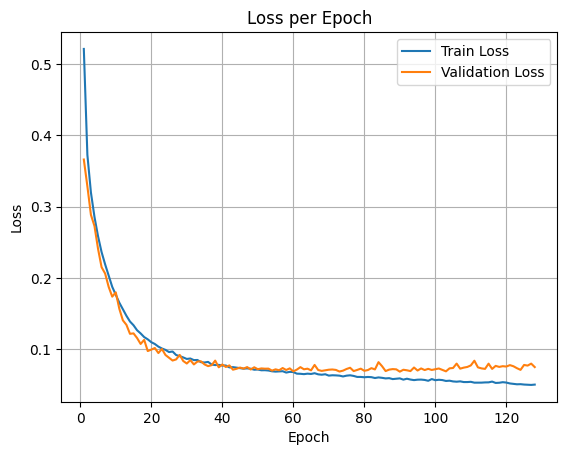

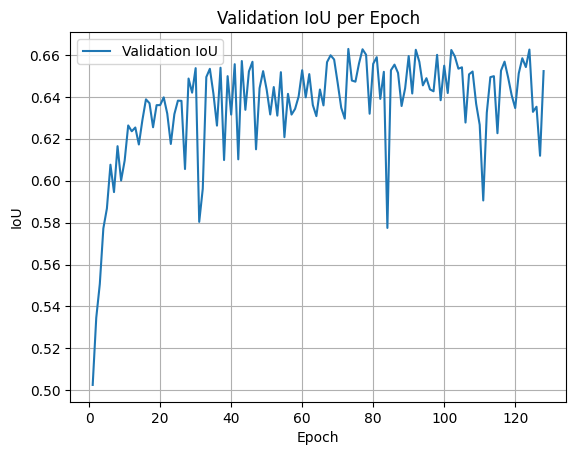

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Validation IoU per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

class BirdSoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        image = image.resize(self.target_size)
        mask = mask.resize(self.target_size)
        
        mask = np.array(mask) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [14]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


# 3.Evaluate your model using the test images

In [18]:
from sklearn.metrics import jaccard_score
from tqdm import tqdm

def calculate_iou(y_true, y_pred):
    y_true = (y_true > 0.5).float().view(-1).cpu().numpy()
    y_pred = (y_pred > 0.5).float().view(-1).cpu().numpy()
    return jaccard_score(y_true, y_pred, average="binary")


test_dataset = BirdSoundDataset(
    "new_dataset/test/images", 
    "new_dataset/test/masks", 
    transform, 
    target_size=(256, 256)
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def test_model(model, test_loader, save_path):

    model.load_state_dict(torch.load(save_path,map_location=torch.device('mps')))
    model.to(device)
    model.eval()

    test_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            test_iou += calculate_iou(masks, preds)
            num_samples += 1

    average_test_iou = test_iou / num_samples
    print(f"Test Set IoU: {average_test_iou * 100:.2f}%")
    return average_test_iou

save_path = "best_model-2.pth"
model = AtrousSegNet().to(device)
test_iou = test_model(model, test_loader, save_path)

/var/folders/n9/44t9prp94l3b1lknw4mfg4dm0000gn/T/ipykernel_2703/3483314682.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path,ma

Test Set IoU: 65.33%


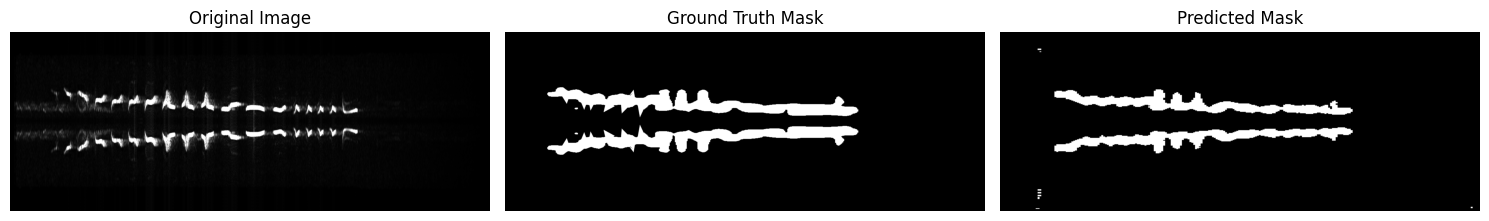

In [21]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt


original_image_path = 'new_dataset/test/images/XC79031_left.png'
mask_image_path = 'new_dataset/test/masks/XC79031_left.png'

original_image = cv2.imread(original_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image = cv2.resize(original_image, (256, 256))
image = image / 255.0
image = np.transpose(image, (2, 0, 1))
image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)

image = image.to(device)

with torch.no_grad():
    predicted_mask = model(image)
    predicted_mask = torch.sigmoid(predicted_mask).squeeze().cpu().numpy()

predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

predicted_mask_resized = cv2.resize(
    predicted_mask_binary, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_image, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_resized, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


# 4. Your IoU score should be higher than 60

### Results
### Testing: 100%|██████████| 19/19 [00:22<00:00,  1.20s/it]
### Test Set IoU: 65.33%

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


## https://www.researchgate.net/publication/387180246_Noise_Isolation_in_Bird_Sound_Images_Using_AtrousSegNet_with_Multi-Scale_Contextual_Learning